Данный скрипт позволяет перевести данные из лабораторной СО в СО тела. Это уменьшает дисперсии условно неподвижных маркеров и предположительно улучшает качество данных.
Кроме того, составляется файл-отчёт со стандартными отклонениями маркеров в обеих СО

In [ ]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [268]:
#Все маркеры
markers = ['RAH', 'RPH', 'LAH', 'LPH', 'C7', 'T8', 'IJ', 'PX','RSC', 'RAC','LSC', 'LAC', 'RAI', 'RPC',
           'RTS', 'RAA', 'LAI', 'LTS', 'LAA', 'LPC', 'REM', 'REL', 'LEM', 'LEL', 'RRS', 'RUS', 'LRS', 'LUS', 'LSJ', 'RSJ']
#Маркеры, условно неподвижные относительно тела
stablemarkers = ['T8', 'IJ', 'PX', 'C7']
#Маркеры лопатки
markersscap = ['RTS', 'RAI', 'RAA']
#Хранит названия колонок в списке
cols = []
stablecols = []
scapulacols = []
#Хранит названия колонок в строке
csvcols = ''
for i in markers:
    cols.append(i + 'x')
    cols.append(i + 'y')
    cols.append(i + 'z')
    csvcols += cols[-3] + '\t' + cols[-2] + '\t' + cols[-1] + '\t'
for i in stablemarkers:
    stablecols.append(i + 'x')
    stablecols.append(i + 'y')
    stablecols.append(i + 'z')
for i in markersscap:
    scapulacols.append(i + 'x')
    scapulacols.append(i + 'y')
    scapulacols.append(i + 'z')

In [288]:
#Файлы для обработки
files = ['1.trc', '2.trc','3.trc','4.trc','5.trc','6.trc','7.trc','8.trc','9.trc','9_combined.trc','9_left.trc','9_right.trc',
'10.trc', '11.trc','12.trc','12_shrugging.trc','13.trc','14.trc','14_depression.trc', '14_elevation.trc', 'very long static 14.trc']
#Добавление префикса
for i in range(len(files)):
    files[i] = 'normalized_orig_trc\\' + files[i]
for file in files:
    #Data from original file
    datalines = []
    with open (file, 'r') as fp:
        datalines = fp.readlines()
        infolines = datalines[0:5]
        #infolines[1].replace('NumFrames', 'NumFrame', 1)
        #infolines[1].replace('NumMarkers', 'NumMarker', 1)
        datalines = datalines[5:-1]
    textdatalines = ''
    textinfodatalines = ''
    for i in datalines:
        textdatalines += i + '\n'
    #df хранит данные оригинального файла
    df = pd.read_csv(StringIO(textdatalines), sep = '\t', names = ['Frame#', 'Time'] + cols)
    df1 = df.copy()
    #Still Subject coordinates in laboratory frame. Describes the movement of the point, which is still relatively the body
    SSx = np.zeros(len(df.index))
    SSy = np.zeros(len(df.index))
    SSz = np.zeros(len(df.index))

    for i in stablecols:
        if 'x' in i:
            SSx += np.array(df1[i])
        elif 'y' in i:
            SSy += np.array(df1[i])
        elif 'z' in i:
            SSz += np.array(df1[i])

    SSx /= len(stablecols) 
    SSy /= len(stablecols)
    SSz /= len(stablecols)
    
    #10, 120, 20 - константы, подобранные в графическом интерфейсе, достаточно точно совмещающие экспериментальное
    #расположение маркеров с модельным. Константы могут быть другими для других эксп. данных
    for i in cols:
        if 'x' in i:
            for j in range(len(df1[i].values)):
                df1[i].values[j] -= SSx[j]
                df1[i].values[j] += 10
        elif 'y' in i:
            for j in range(len(df1[i].values)):
                df1[i].values[j] -= SSy[j]
                df1[i].values[j] += 120
        elif 'z' in i:
            for j in range(len(df1[i].values)):
                df1[i].values[j] -= SSz[j]
                df1[i].values[j] += 20

    #Запись данных в файл
    newinfolines = infolines
    newinfolines[0] = "PathFileType\t4\t(X/Y/Z)\\" + file[0:-4] + '_shifted.trc\n'
    newinfolines[2] = '100\t100\t' + str(len(df1)+1) + '\t30\tmm\t100\t' + str(df1['Time'].values[0]) + '\t' + str(len(df1)+1) + '\n'
    newtextlines = df1.to_csv(sep = '\t', header=False, index = False)
    newtextlines = ''.join(newinfolines) + newtextlines
    with open (file[0:-4] + '_shifted.trc', 'w+') as fp:
        fp.write(newtextlines)
    #Файл со стандартными отклонениями описыват дисперсии маркеров в лабораторной СО и СО тела
    with open (file[0:-4] + '_stdinfo.txt', 'w+') as fp:
        fp.write('std_lab - std_body: <Marker> <std, mm>\n')
        for i in cols:
            fp.write(i+': %.2f\n' %(df[i].std() - df1[i].std()))
        fp.write('In laboratory frame: <Marker> <std, mm>\n')
        for i in cols:
            fp.write(i + ' %.2f\n' %(df[i].std()))
        fp.write('In body frame: <Marker> <std, mm>\n')
        for i in cols:
            fp.write(i + ' %.2f\n' %(df1[i].std()))

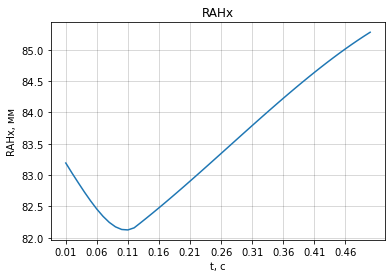

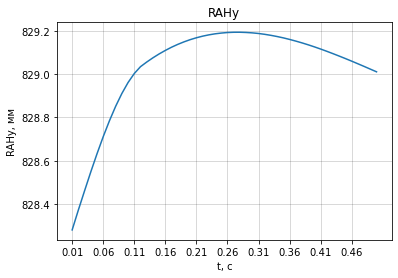

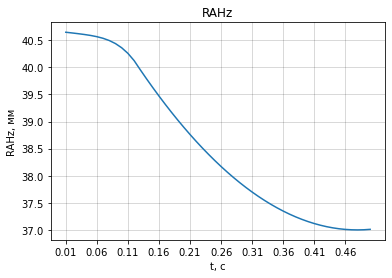

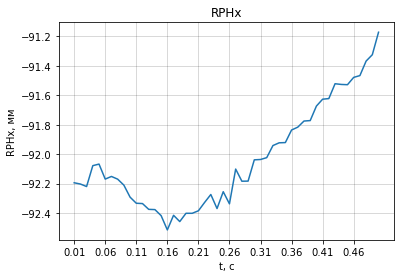

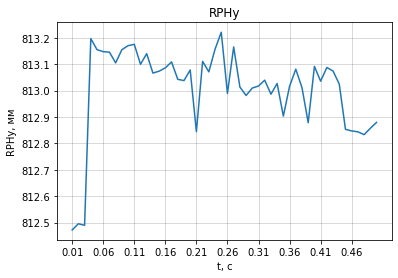

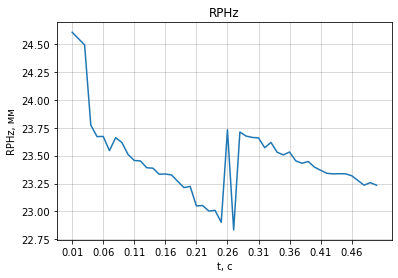

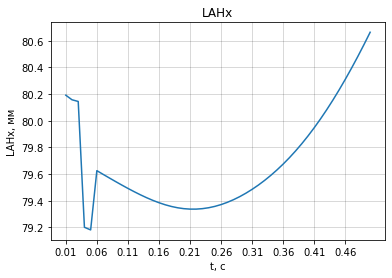

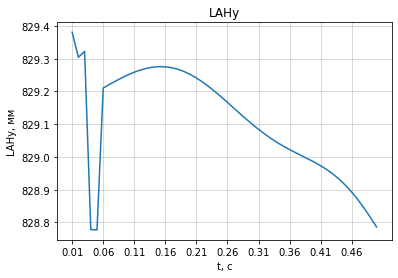

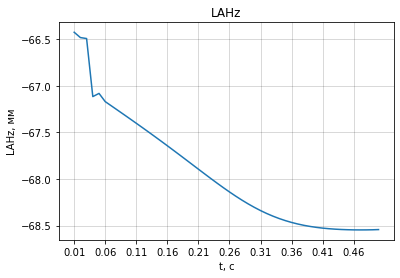

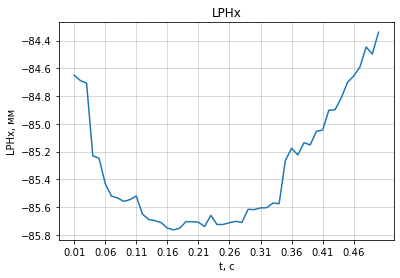

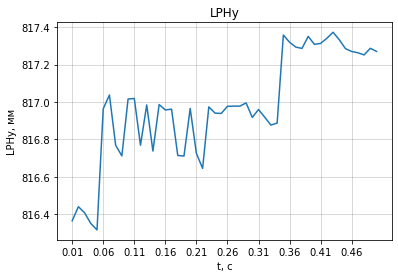

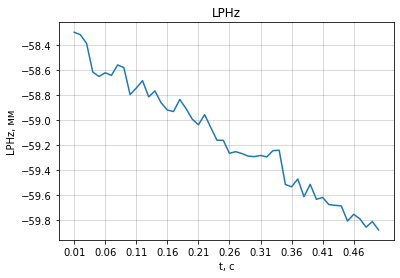

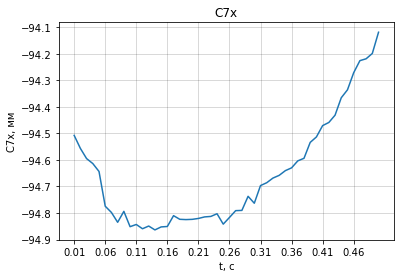

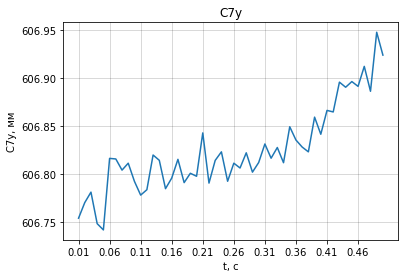

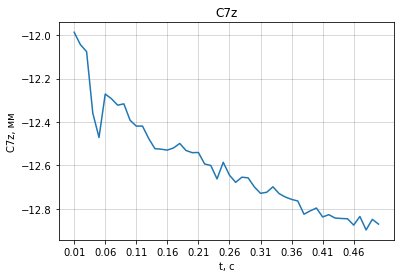

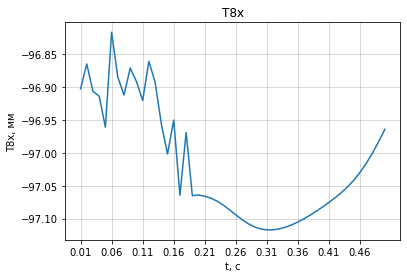

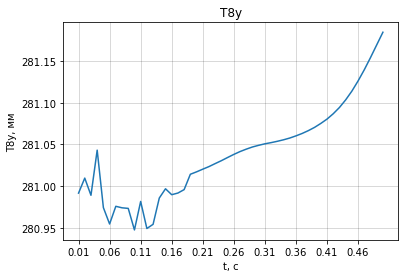

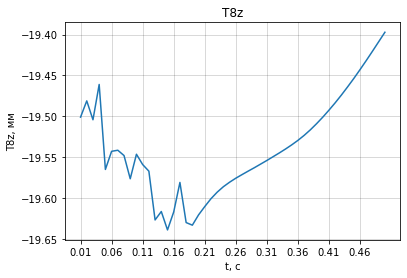

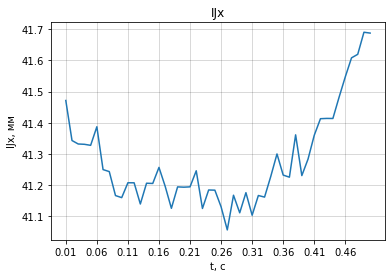

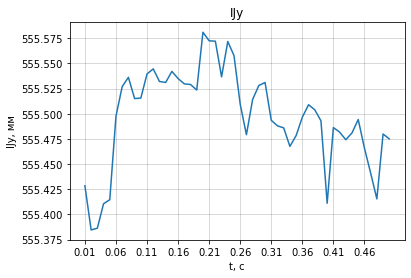

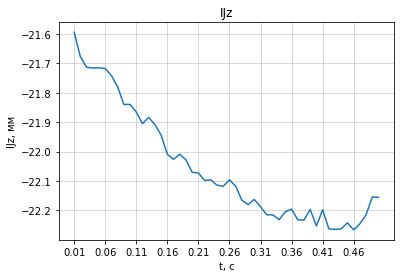

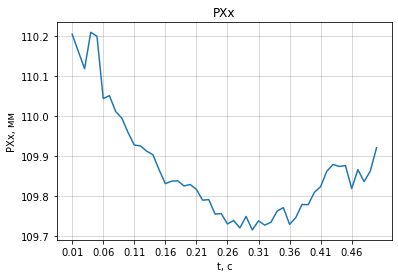

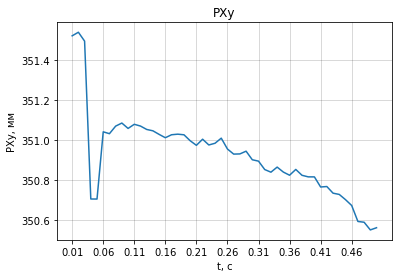

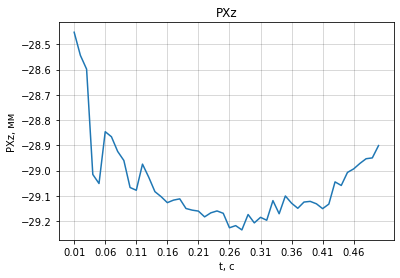

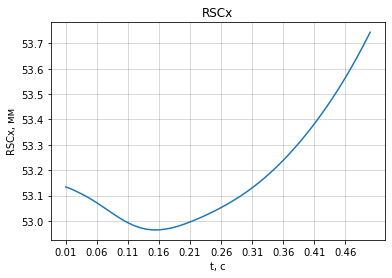

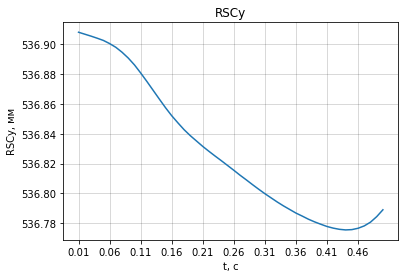

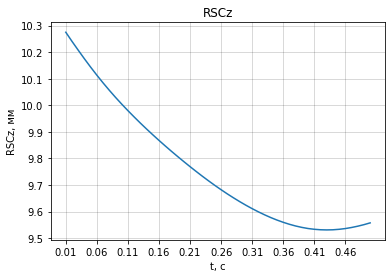

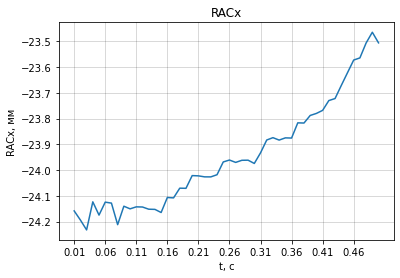

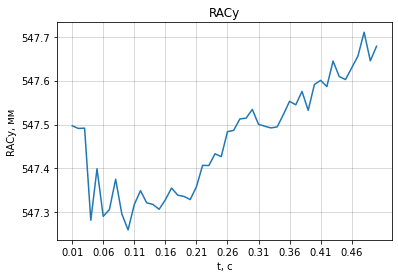

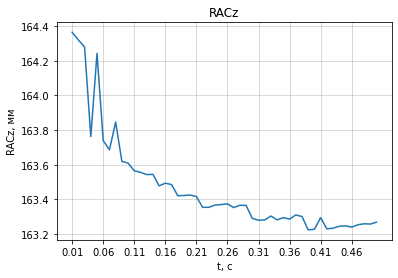

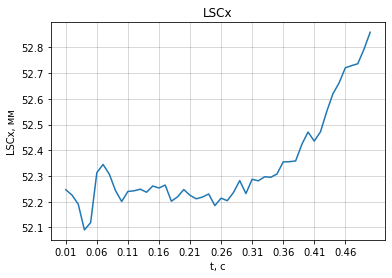

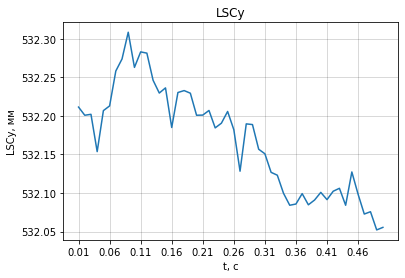

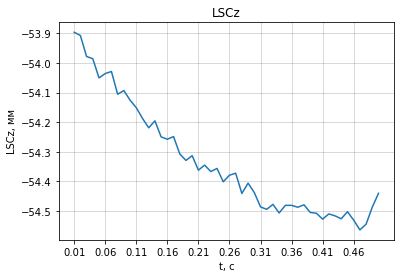

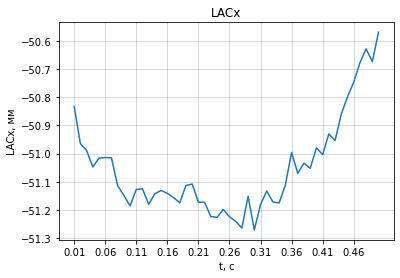

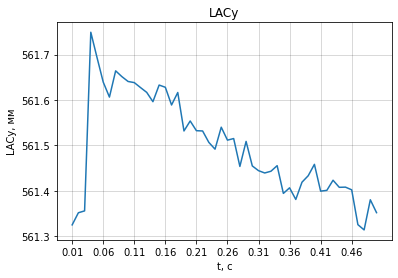

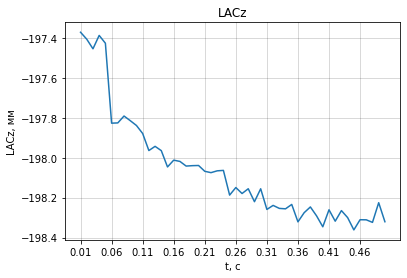

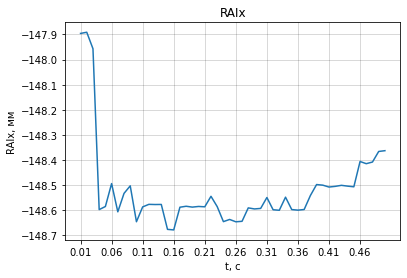

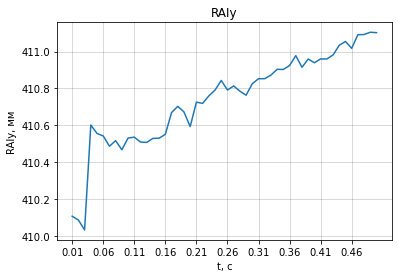

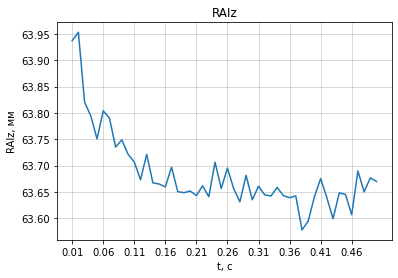

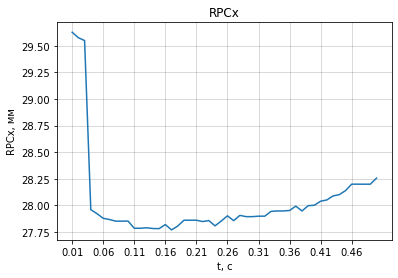

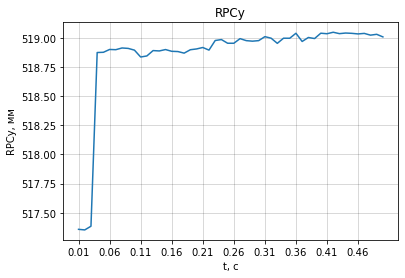

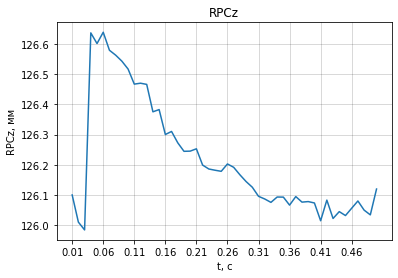

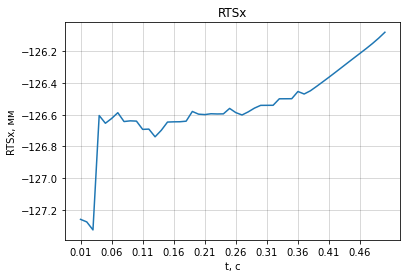

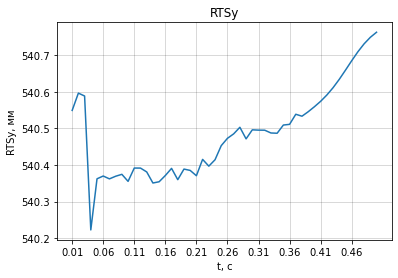

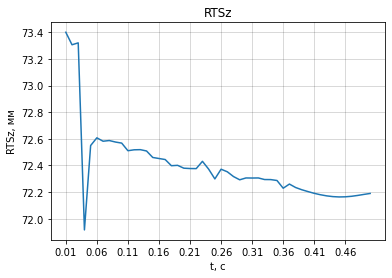

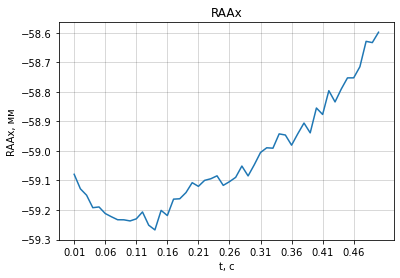

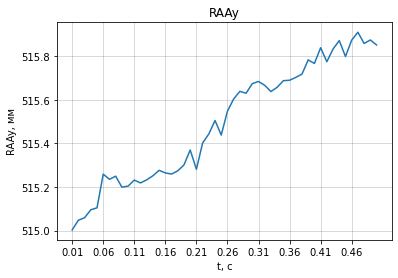

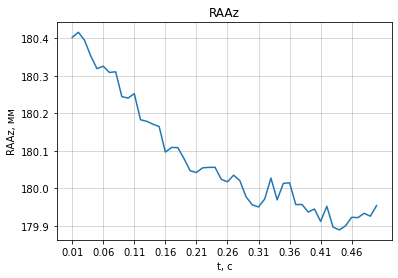

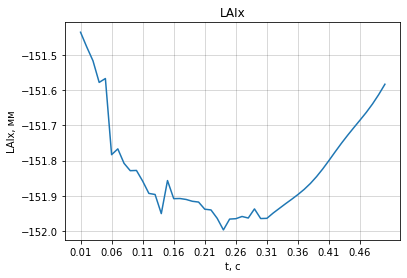

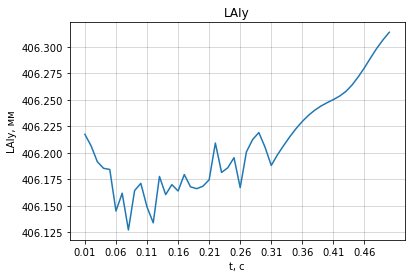

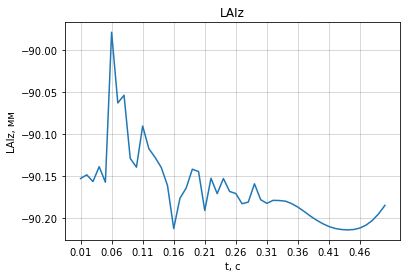

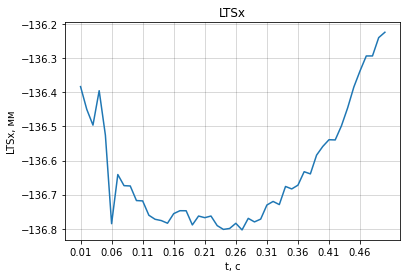

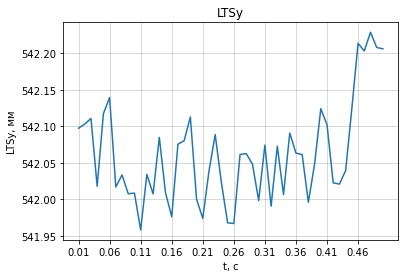

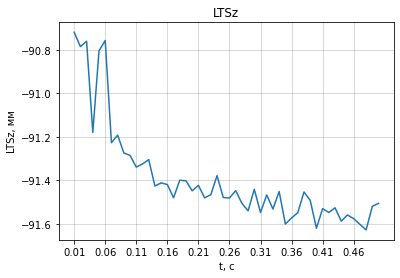

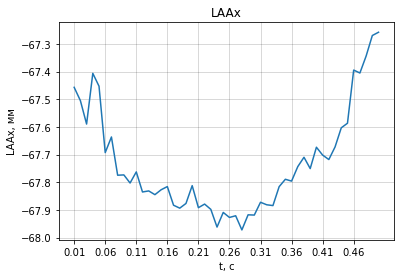

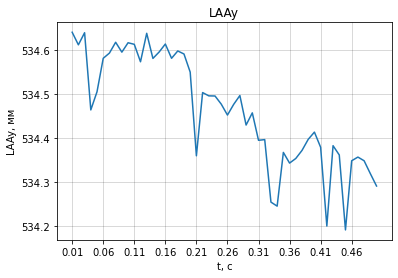

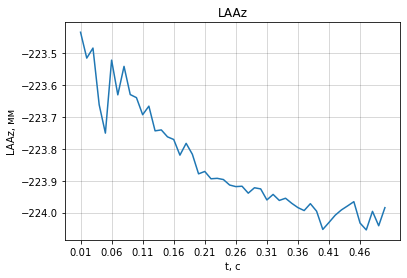

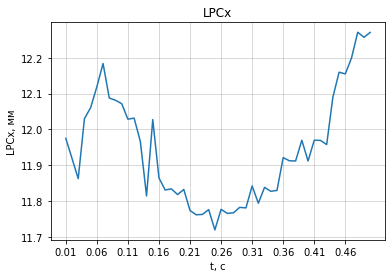

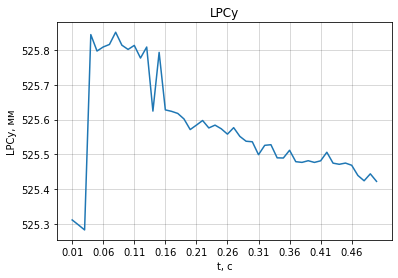

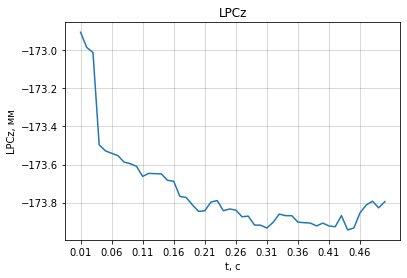

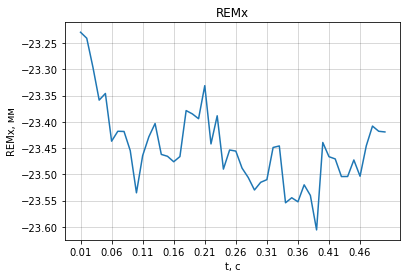

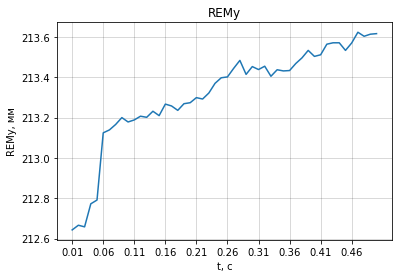

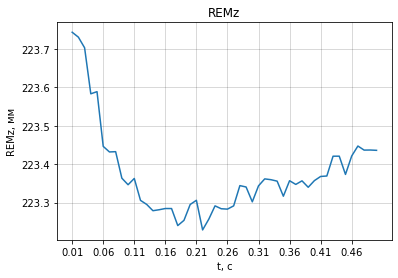

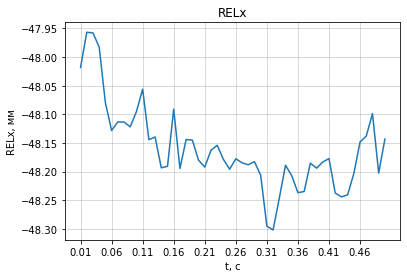

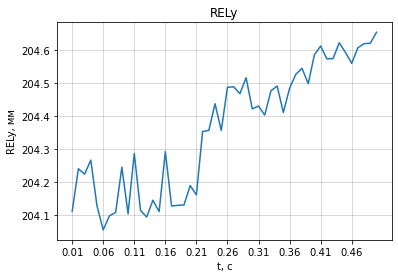

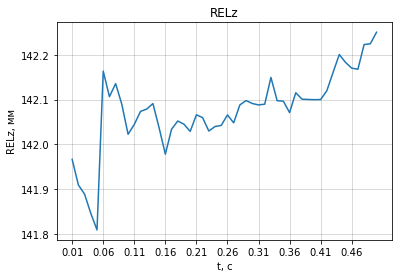

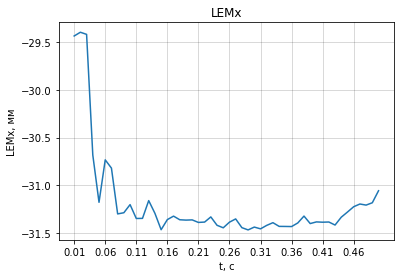

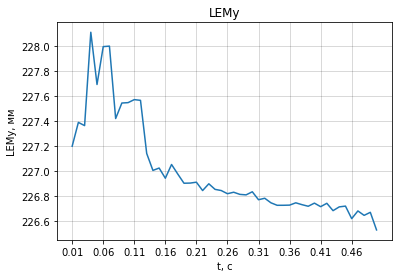

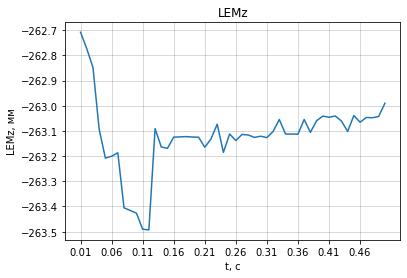

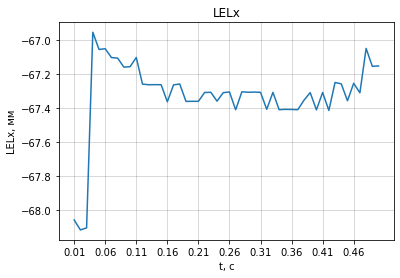

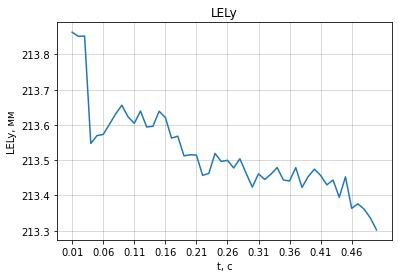

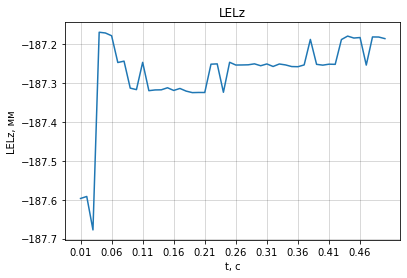

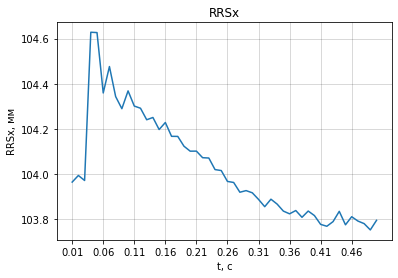

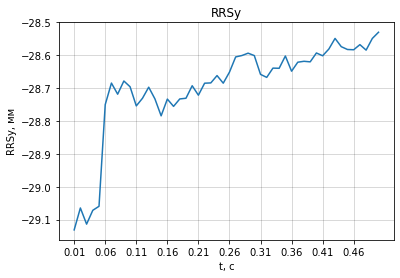

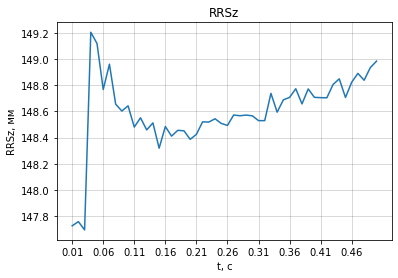

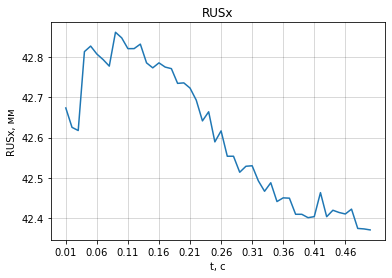

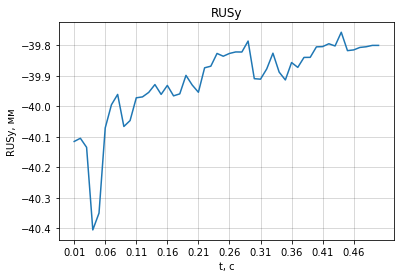

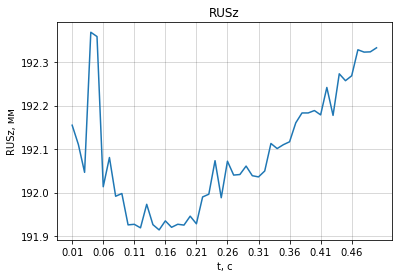

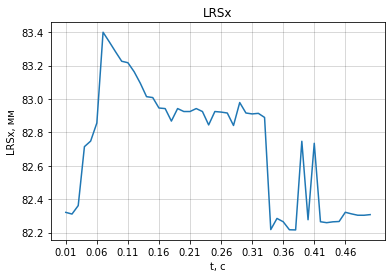

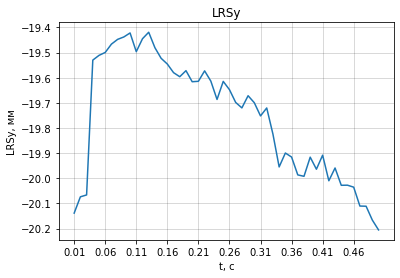

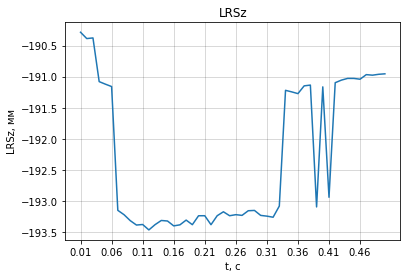

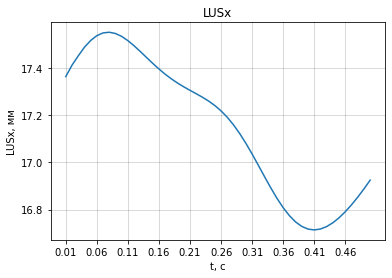

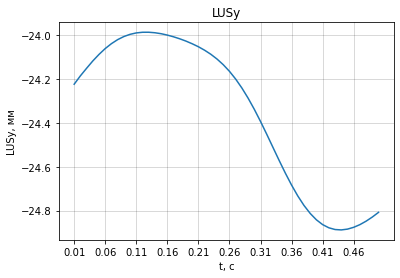

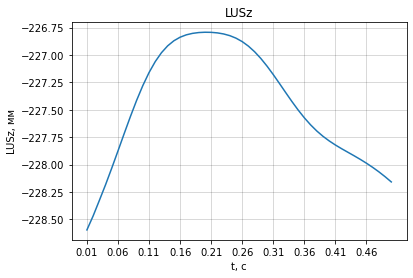

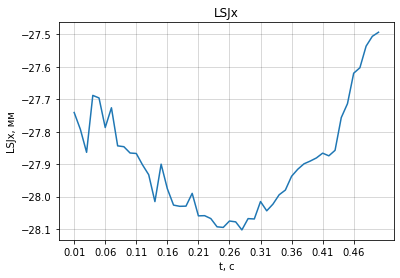

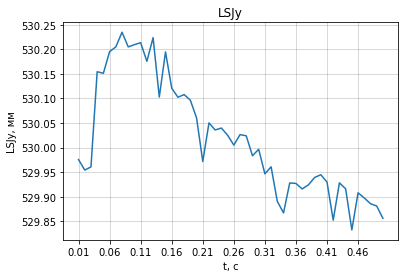

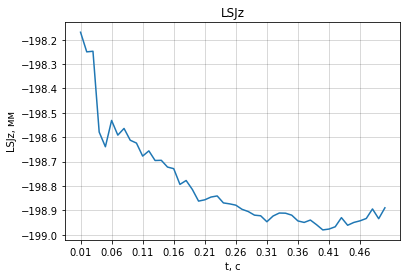

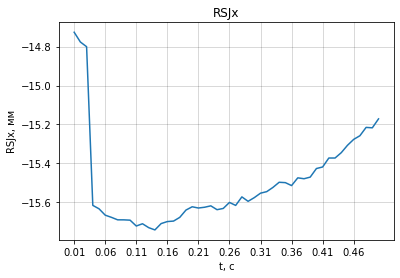

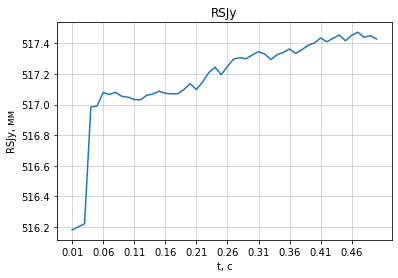

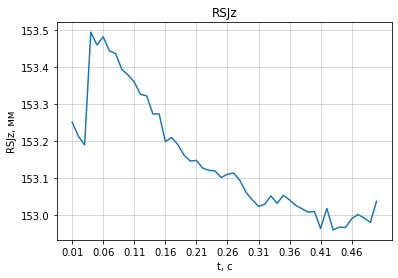

In [157]:
#Визуализация
for i in cols:
    fig, ax = plt.subplots()
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    plt.xticks(np.arange(min(df2['Time']), max(df2['Time']), 0.05))
    plt.title(i)
    ax.set_xlabel('t, с')
    ax.set_ylabel(i + ', мм')
    ax.plot(df2['Time'], df2[i])
    #ax.plot(df['Time'], df[i])
    plt.show()

In [289]:
print('Relatively lab:')
for i in cols:#['RAAx', 'RAIy','RTSy','RRSz', 'C7x', 'C7y','C7z', 'T8x', 'T8y','T8z', 'PXx', 'PXy', 'PXz', 'IJx', 'IJy', 'IJz']:
    print('std of ', i, ' equals ', df[i].std())

Relatively lab:
std of  RAHx  equals  2.4838579971645416
std of  RAHy  equals  0.27312958321175546
std of  RAHz  equals  1.6170389810440666
std of  RPHx  equals  2.561438724360854
std of  RPHy  equals  0.5054845075378405
std of  RPHz  equals  1.1361036168409056
std of  LAHx  equals  2.4719982100562334
std of  LAHy  equals  0.19795371386334273
std of  LAHz  equals  1.5276929226600304
std of  LPHx  equals  2.5577229405796045
std of  LPHy  equals  0.26458249358418984
std of  LPHz  equals  1.3246966286685677
std of  C7x  equals  2.465589843656183
std of  C7y  equals  0.386746989818368
std of  C7z  equals  0.8847775146993575
std of  T8x  equals  2.6059537155839907
std of  T8y  equals  0.3117163237423254
std of  T8z  equals  0.49540990514083083
std of  IJx  equals  2.39406390653422
std of  IJy  equals  0.6549004142145964
std of  IJz  equals  1.0201043769224232
std of  PXx  equals  2.310833368134058
std of  PXy  equals  1.5194524174880437
std of  PXz  equals  0.6909819462291417
std of  RSCx  

In [274]:
print('Relatively body:')
for i in cols:#['RAAx', 'RAIy','RTSy','RRSz', 'C7x', 'C7y','C7z', 'T8x', 'T8y','T8z', 'PXx', 'PXy', 'PXz', 'IJx', 'IJy', 'IJz']:
    print('std of ', i, ' equals ', df1[i].std())

Relatively body:
std of  RAHx  equals  19.841875886350472
std of  RAHy  equals  2.8379909475770986
std of  RAHz  equals  6.06406688367716
std of  RPHx  equals  19.29495569859542
std of  RPHy  equals  3.885096913980302
std of  RPHz  equals  6.225661341330718
std of  LAHx  equals  15.045080460050478
std of  LAHy  equals  2.7447692852365337
std of  LAHz  equals  5.467063795893044
std of  LPHx  equals  15.688208726423301
std of  LPHy  equals  4.167407956173553
std of  LPHz  equals  5.6494283546039785
std of  C7x  equals  15.08612059062961
std of  C7y  equals  6.995438432057948
std of  C7z  equals  4.168823689343405
std of  T8x  equals  12.499430460357313
std of  T8y  equals  3.807582695909611
std of  T8z  equals  2.3307896723862154
std of  IJx  equals  13.768209416086098
std of  IJy  equals  5.149434057608152
std of  IJz  equals  2.80940880315065
std of  PXx  equals  14.151733821134423
std of  PXy  equals  5.549517681554007
std of  PXz  equals  3.0146947968432456
std of  RSCx  equals  13.1